# Segmenting Biological Tissue Images

This notebook provides you with a complete code example that segments the images of a biological tissue using a U-Net employing early stopping to prevent overfitting.

## Loading the Dataset with Segmented Tissue Images

The dataset consists of 20 serial section Transmission Electron Microscopy (ssTEM) images of the ventral nerve cord of the Drosophila melanogaster, a fruit fly, whose size is 1024 x 1024 pixels. In addition to the ssTEM images, the dataset also contains ground-truth segmentations of the neuronal structures. 
For simplicity, you'll only consider the segmentation of the neuronal intracellular regions and mitochondria.

Download the dataset ...

In [1]:
import os

if not os.path.exists("tissue_images_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/tissue_images_dataset")

raw_path = os.path.join("tissue_images_dataset", "stack1", "raw")
label_path = os.path.join("tissue_images_dataset", "stack1", "labels")

... create the sources to manage the images during training ...

In [2]:
import deeptrack as dt

raw_paths = dt.sources.ImageFolder(root=raw_path)
label_paths = dt.sources.ImageFolder(root=label_path)
paths = dt.sources.Source(raw=raw_paths, label=label_paths)
train_paths, val_paths, test_paths = \
    dt.sources.random_split(paths, [0.8, 0.1, 0.1])

train_srcs = train_paths.product(flip_ud=[True, False], flip_lr=[True, False])
val_srcs = val_paths.constants(flip_ud=False, flip_lr=False)
test_srcs = test_paths.constants(flip_ud=False, flip_lr=False)

sources = dt.sources.Join(train_srcs, val_srcs, test_srcs)

## Creating the Data Pipelines

Implement a function to filter the labels in the segmentation map ...

In [3]:
import numpy as np

def select_labels(class_labels):
    """Create a function to filter and remap labels in a segmentation map."""    
    def inner(segmentation):
        seg = segmentation.copy()
        mask = seg * np.isin(seg, class_labels).astype(np.uint8)
        replace = np.arange(len(class_labels)) + 1
        new_seg = (np.select([mask == c for c in class_labels], replace)
                   .astype(np.uint8).squeeze())
        return np.eye(len(class_labels) + 1)[new_seg]  # One-hot encoded.
    return inner

... define the pipelines ...

In [4]:
import torch

im_pip = dt.LoadImage(sources.raw.path) >> dt.NormalizeMinMax()
lab_pip = dt.LoadImage(sources.label.path) \
          >> dt.Lambda(select_labels, class_labels=[255, 191])
pip = (im_pip & lab_pip) >> dt.FlipLR(sources.flip_lr) \
      >> dt.FlipUD(sources.flip_ud) >> dt.MoveAxis(2, 0) \
      >> dt.pytorch.ToTensor(dtype=torch.float)

... define the training and validation datasets ...

In [5]:
train_dataset = dt.pytorch.Dataset(pip, train_srcs)
val_dataset = dt.pytorch.Dataset(pip, val_srcs)

... and plot the input image and corresponding ground-truth segmentation.

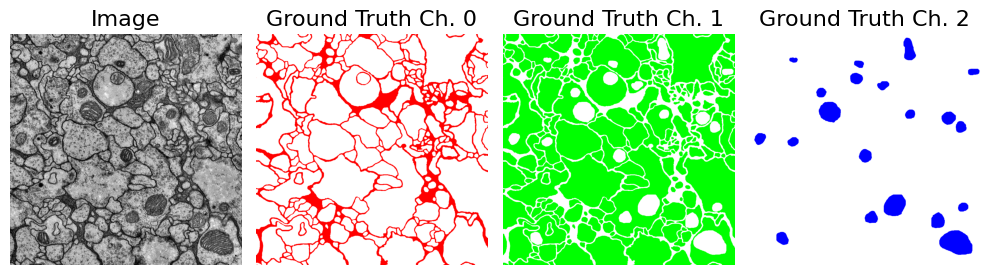

In [6]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

fig, axs = plt.subplots(1, 4, figsize=(10, 5))

axs[0].imshow(image.permute(1, 2, 0), cmap="gray")
axs[0].set_title("Image", fontsize=16)
axs[0].set_axis_off()

for i in range(label.shape[0]):
    label_color = torch.ones_like(label)
    for j in range(label.shape[0]): 
        if j != i: label_color[j, ...] = 1 - label[i, ...]
    axs[i + 1].imshow(label_color.permute(1, 2, 0))
    axs[i + 1].set_title(f"Ground Truth Ch. {i}", fontsize=16)
    axs[i + 1].set_axis_off()
    
plt.tight_layout()
plt.savefig('fig_05_02.pdf', bbox_inches='tight')  ### plt.show()

## Defining and Training the U-Net

Define a class to compute Jaccard Index for multi-class predictions after taking the
channel with the maximum value ...

In [7]:
from torchmetrics.classification import MulticlassJaccardIndex

class ArgmaxJI(MulticlassJaccardIndex):
    """Compute Jaccard Index for multi-class predictions after argmax."""
    
    def update(self, preds, targets):
        """Update Jaccard Index using argmax-applied class predictions."""
        super().update(preds.argmax(dim=1), targets.argmax(dim=1))

... define and compile the U-Net ...

In [8]:
import deeplay as dl

ji_metric = ArgmaxJI(num_classes=3)
        
unet = dl.UNet2d(in_channels=1, channels=[16, 32, 64, 128], out_channels=3,
                 skip=dl.Cat())
unet_reg_template = dl.Regressor(model=unet, loss=torch.nn.CrossEntropyLoss(),
                                 metrics=[ji_metric], optimizer=dl.Adam())
unet_reg = unet_reg_template.create()

print(unet_reg)

Regressor(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (ArgmaxJI): ArgmaxJI(),
    prefix=test
  )
  (model): UNet2d(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation):

... define the training and validation data loaders ...

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

... and training the U-Net.

In [10]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("logs", name="train_100_epochs")
trainer = dl.Trainer(max_epochs=100, accelerator="auto", logger=logger)
trainer.fit(unet_reg, train_loader, val_loader)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ UNet2d           │  526 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 526 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 526 K                                                                                                
Total estimated model params size (MB): 2

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.

## Observing Overfitting

Implement a function to plot the training metrics ...

In [11]:
def plot_training_metrics(m, fig_name):  ### def plot_training_metrics(m):
    """Plot training metrics by epoch."""
    fig, axs = plt.subplots(2, figsize=(6, 4))

    axs[0].plot(m["epoch"], m["train_loss_epoch"], label="Train Loss")
    axs[0].plot(m["epoch"], m["val_loss_epoch"], label="Validation Loss")
    axs[0].set_xlabel("Epoch"); axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(m["epoch"], m["trainArgmaxJI_epoch"], label="Train JI")
    axs[1].plot(m["epoch"], m["valArgmaxJI_epoch"], label="Validation JI")
    axs[1].set_xlabel("Epoch"); axs[1].set_ylabel("Jaccard Index (JI)")
    axs[1].legend()

    plt.tight_layout()
    plt.savefig(fig_name, bbox_inches='tight')  ### plt.show()

... and plot the training and validation metrics ...

/var/folders/nk/vplzgbvj0w1gpgk5h_j226480000gp/T/ipykernel_65901/2114474045.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metrics = metrics.fillna(method="ffill")


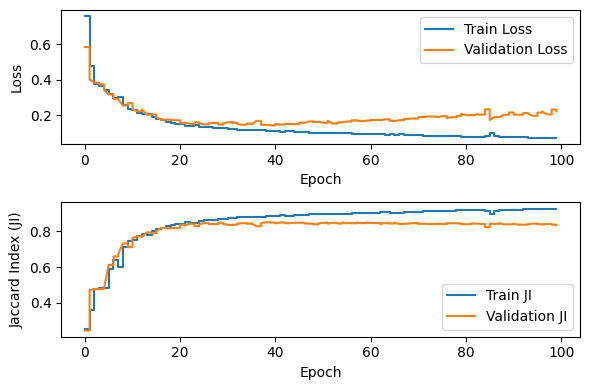

In [12]:
import pandas as pd

metrics = pd.read_csv(os.path.join(logger.log_dir, "metrics.csv"))
metrics = metrics.fillna(method="ffill")
plot_training_metrics(metrics, fig_name='fig_05_03.pdf')  ### plot_training_metrics(metrics)

## Preventing Overfitting

Train U-Net with early stopping to prevent overfitting ...

In [13]:
from lightning.pytorch.callbacks import EarlyStopping

early_stop_unet_reg = unet_reg_template.create()

early_stop = EarlyStopping(monitor="valArgmaxJI_epoch", mode="max", patience=5)
early_stop_logger = CSVLogger("logs", name="train_until_stagnation")

early_stop_trainer = dl.Trainer(max_epochs=100, logger=early_stop_logger, 
                                callbacks=[early_stop])
early_stop_trainer.fit(early_stop_unet_reg, train_loader, val_loader)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ UNet2d           │  526 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 526 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 526 K                                                                                                
Total estimated model params size (MB): 2

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/py
torch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.

... plot the training and validation metrics with early stopping ...

/var/folders/nk/vplzgbvj0w1gpgk5h_j226480000gp/T/ipykernel_65901/1807383859.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metrics = metrics.fillna(method="ffill")


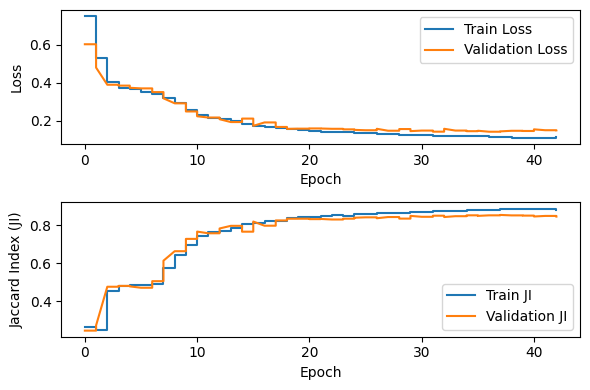

In [14]:
metrics = pd.read_csv(os.path.join(early_stop_logger.log_dir, "metrics.csv"))
metrics = metrics.fillna(method="ffill")
plot_training_metrics(metrics, fig_name='fig_05_04.pdf')  ### plot_training_metrics(metrics)

## Evaluating the Trained U-Net

Estimate the segmentations with the U-Net ...

In [15]:
test_dataset = dt.pytorch.Dataset(pip, test_srcs)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
trainer.test(early_stop_unet_reg, test_loader)
predicted_labels = torch.cat(trainer.predict(early_stop_unet_reg, test_loader), 
                             dim=0)

Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    testArgmaxJI_epoch     │    0.8249546885490417     │
│      test_loss_epoch      │    0.1669994592666626     │
└───────────────────────────┴───────────────────────────┘

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


... plot the U-Net result against the ground truth segmentation ...

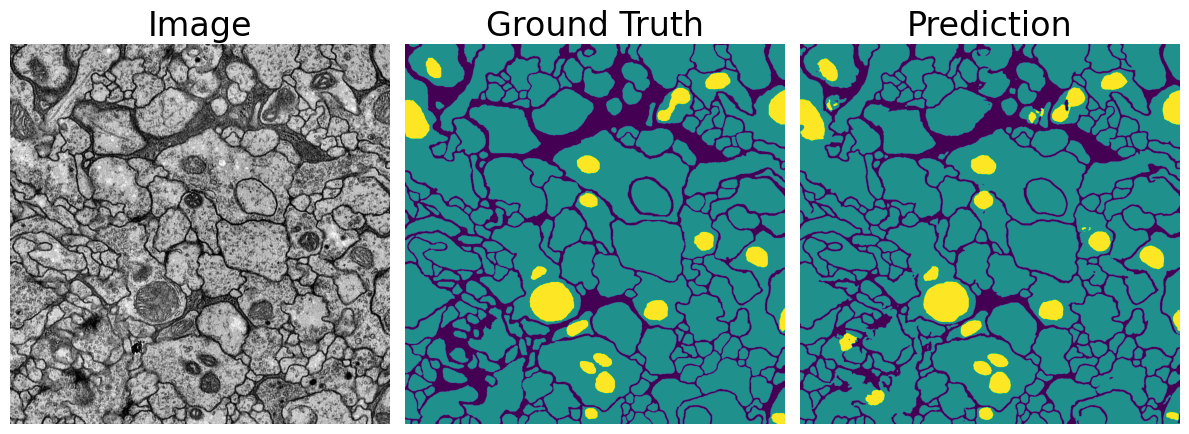

In [16]:
test_image, test_label = test_dataset[0]

fig, axs = plt.subplots(1, 3, figsize=((12, 9)))

axs[0].imshow(test_image[0], cmap="gray")
axs[0].set_title("Image", fontsize=24)
axs[0].set_axis_off()

axs[1].imshow(test_label.argmax(dim=0))
axs[1].set_title("Ground Truth", fontsize=24)
axs[1].set_axis_off()

axs[2].imshow(predicted_labels[0].argmax(dim=0))
axs[2].set_title("Prediction", fontsize=24)
axs[2].set_axis_off()

plt.tight_layout()
plt.savefig('fig_05_05.pdf', bbox_inches='tight')  ### plt.show()

... and calcualte the test Jaccard Index.

In [17]:
ji_metric.reset()
ji_image = ji_metric(predicted_labels[0].unsqueeze(0), test_label.unsqueeze(0))